[Reference](https://itnext.io/boost-your-data-science-with-ranking-in-python-and-pandas-911080128e1)

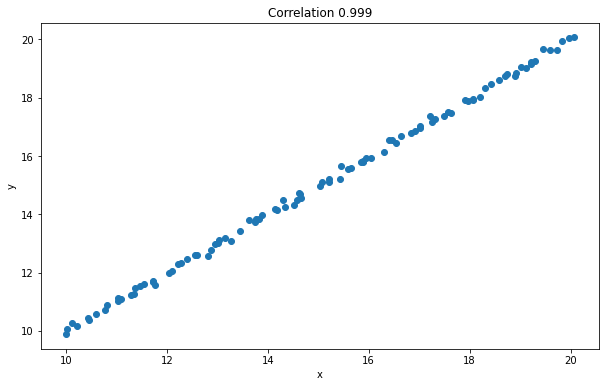

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# helper function to plot
def plot_with_title(ax, x, y, print_spearman_correlation=False):
    ax.scatter(x, y)
    # construct title
    title = f"Correlation {pearsonr(x, y)[0]:.3f}"
    if print_spearman_correlation:
        title += f", Spearman correlation {spearmanr(x, y)[0]:.3f}"
    ax.set_title(title)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
# first we generate some data

size = 100
x = np.linspace(10, 20, 100) + np.random.normal(0, 0.1, size=size)
# almost identical
y = x + np.random.normal(0, 0.1, size=size)
    
# plot and show correlation as title
fig, ax = plt.subplots(figsize=(10, 6))
plot_with_title(ax, x, y)
plt.show()

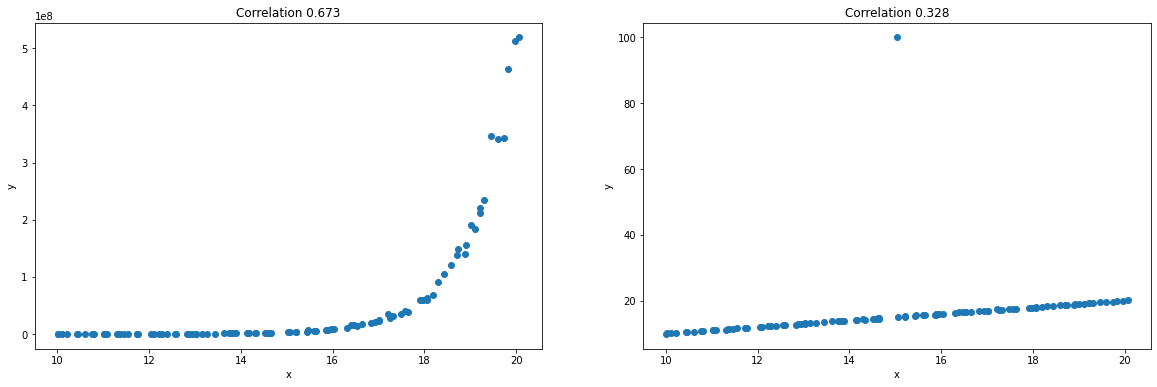

In [2]:
# create two plots beside each other, i.e. 2 cols
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))

# first plot (left): take the exponential of y
plot_with_title(axes[0], x, np.exp(y))

# second plot (right): add an outlier in the middle of y
# (copy to not mutate y)
z = y.copy()
z[z.shape[0]//2] = 100
plot_with_title(axes[1], x, z)
plt.show()

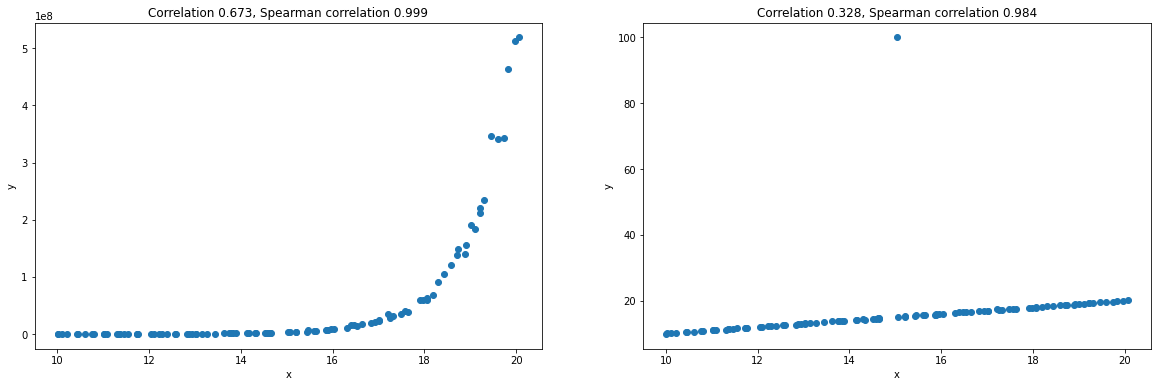

In [3]:
# same plots as before, but with added print_spearman_correlation=True
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
plot_with_title(axes[0], x, np.exp(y), print_spearman_correlation=True)
z = y.copy()
z[z.shape[0]//2] = 100
plot_with_title(axes[1], x, z, print_spearman_correlation=True)
plt.show()

In [4]:
# create random df with 2 columns and 200 rows
df = pd.DataFrame(np.random.uniform(size=(200, 2)))
print(df.rank())
print(df.corr(method="spearman"))

         0      1
0     57.0  126.0
1     62.0  109.0
2     31.0  127.0
3     67.0  174.0
4    126.0   10.0
..     ...    ...
195    6.0  160.0
196   30.0   98.0
197  188.0  145.0
198   78.0  192.0
199  124.0  131.0

[200 rows x 2 columns]
         0        1
0  1.00000  0.07563
1  0.07563  1.00000


In [6]:
# from scipy.io.arff import loadarff

# df, info = loadarff("EEG Eye State.arff")
# df = pd.DataFrame(df, columns=info.names())
# df["eyeDetection"] = df["eyeDetection"].astype(int)
# print(df.head())

In [7]:
# # no scaling
# fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
# df["AF3"].plot(ax=axes[0])
# axes[0].set_title("No transformation")
# # rank
# df["AF3"].rank().plot(ax=axes[1])
# axes[1].set_title("Ranked transformation")
# plt.show()

In [8]:
# std_scaled_df = df.pipe(lambda x: (x - x.mean()) / x.std())
# max_min_scaled_df = df.pipe(lambda x: (x - x.min()) / (x.max() - x.min()))
# ranked_df = df.rank()
# for title, data in [
#         ("Standard scaled", std_scaled_df), 
#         ("Max-min scaled", max_min_scaled_df), 
#         ("Ranked", ranked_df)
#     ]:
#     plt.subplots(figsize=(10, 6))
#     # .T for transpose to get rows (timesteps) as x-axis
#     plt.imshow(data.values.T, aspect="auto")
#     plt.title(title)
#     # add column labels on the yaxis
#     plt.yticks(ticks=np.arange(data.shape[1]), labels=data.columns)
#     plt.ylabel("Features")
#     plt.xlabel("Time point")
#     plt.colorbar()
#     plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
   
# load data
x, y = fetch_california_housing(return_X_y=True, as_frame=True)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(16512, 8) (4128, 8) (16512,) (4128,)


In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

model = Pipeline([
    ("preprocessing", StandardScaler()),
    ("model", MLPRegressor(max_iter=10000, random_state=1234))
])
model.fit(x_train, y_train)
print(mean_squared_error(y_test, model.predict(x_test)))

0.2943268522138416


In [11]:
from sklearn.base import BaseEstimator, TransformerMixin

class RankTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        """
            cols - columns to perform transformation on
        """
        self.cols = cols
    
    def fit(self, x, y=None):
        ranks = x.rank()
        # add the ranks as index for each column,
        # a dict is used since each column has
        # different ranks
        self._ranks = {
            c: pd.Series(x[c].values, index=ranks[c].values).drop_duplicates()
            for c in self.cols
        }
        return self
    
    def fit_transform(self, x, y=None):
        self.fit(x)
        return self.transform(x)
    
    def transform(self, x, y=None):
        # to not mutate original data frame
        x = x.copy()
        for c in self.cols:
            # find closest value (minimum distance) and use the rank
            # at that location
            x[c] = x[c].apply(lambda x: (self._ranks[c] - x).abs().idxmin())
        return x

model = Pipeline([
    ("rank transformer", RankTransformer(cols=[
        "AveRooms",
        "AveBedrms",
        "Population",
        "AveOccup"
    ])),
    ("preprocessing", StandardScaler()),
    ("model", MLPRegressor(max_iter=10000, random_state=1234))
])
model.fit(x_train, y_train)
print(mean_squared_error(y_test, model.predict(x_test)))

0.27719883210947716
